# Kaggle COVID-19 Forecasting and Data Analysis

The following notebook has been prepared for the Kaggle COVID-19 Forecasting challenge, where confirmed cases and fatalities as a result of the virus are predicted for all countries.

Creator: Rohan Ravindran

## Stage 1: Data Import

- The Kaggle data for the competition is imported and preped.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
train = pd.read_csv("train.csv", header=0)
test = pd.read_csv("test.csv", header=0)

train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [0]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [0]:
train = train.set_index(['Date'])
test = test.set_index(['Date'])

X_train = train.drop(['Id'], axis=1)
X_valid = test.drop(['ForecastId'], axis=1)

### Adding new time features

- Adding new time series features from the original date feature.

In [0]:
def createNewTimeFeatures(df):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

In [0]:
createNewTimeFeatures(X_train)
createNewTimeFeatures(X_valid)

In [0]:
X_train = X_train.drop(['year'], axis=1)
X_valid = X_valid.drop(['year'], axis=1)

## Stage 2: Adding External Data

- External data including the Human Development Index, World Happiness Index, Malaria Cases, and Google mobility reports are added to our existing dataset to help our model understand how transmission of the virus varies in different countries.

In [0]:
whi_data = pd.read_csv("World_Happiness_Index.csv")
whi_data = whi_data.groupby('Country name').nth(-1)

whi_data.isna().sum()

In [0]:
whi_data.drop(['GINI index (World Bank estimate)', 
               'Most people can be trusted, Gallup', 
               'Most people can be trusted, WVS round 1981-1984',
               'Most people can be trusted, WVS round 1989-1993',
               'Most people can be trusted, WVS round 1994-1998',
               'Most people can be trusted, WVS round 1999-2004',
               'Most people can be trusted, WVS round 2005-2009',
               'Most people can be trusted, WVS round 2010-2014',
               'Democratic Quality',
               'Delivery Quality', 
               'Year'], axis=1, inplace=True)

X_train = pd.merge(left=X_train, right=whi_data, how='left', left_on='Country_Region', right_on='Country name')
X_valid = pd.merge(left=X_valid, right=whi_data, how='left', left_on='Country_Region', right_on='Country name')

Looking at the distribution of data in the malaria data.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


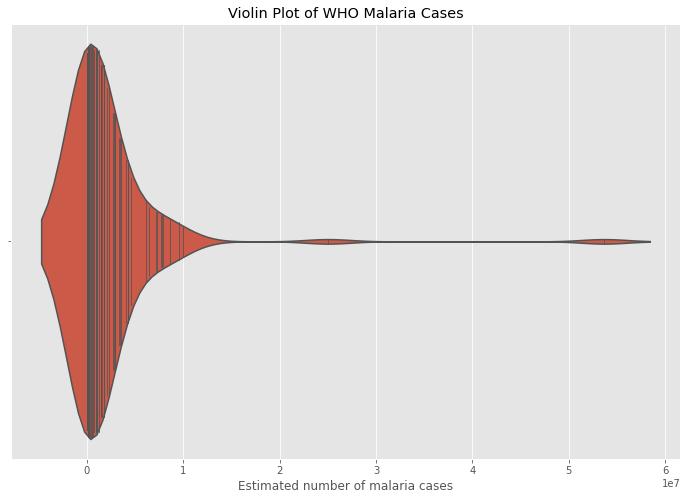

In [9]:
malaria_data = pd.read_csv("Malaria_World_Health_Organization.csv")
malaria_data = malaria_data.groupby('Country').nth(-1)

import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline

style.use('ggplot')

plt.figure(figsize=[12,8])
plt.title('Violin Plot of WHO Malaria Cases')
sns.violinplot(x = malaria_data['Estimated number of malaria cases'], vert=True, inner='stick')

In [0]:
X_train = pd.merge(left=X_train, right=malaria_data, how='left', left_on='Country_Region', right_on='Country')
X_valid = pd.merge(left=X_valid, right=malaria_data, how='left', left_on='Country_Region', right_on='Country')

In [0]:
hdi_data = pd.read_csv('Human_Development_Index.csv')
hdi_data = hdi_data.groupby('Country').nth(-1)

hdi_data['Gross national income (GNI) per capita 2018'] = hdi_data['Gross national income (GNI) per capita 2018'].str.replace(',', '').astype(float)

X_train = pd.merge(left=X_train, right=hdi_data, how='left', left_on='Country_Region', right_on='Country')
X_valid = pd.merge(left=X_valid, right=hdi_data, how='left', left_on='Country_Region', right_on='Country')

In [0]:
population_by_country_data = pd.read_csv('population_by_country_2020.csv')
population_by_country_data = population_by_country_data[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]

population_by_country_data['Urban Pop %'] = population_by_country_data['Urban Pop %'].str.rstrip('%')

population_by_country_data.loc[population_by_country_data['Urban Pop %'] == 'N.A.', 'Urban Pop %'] = int(population_by_country_data.loc[population_by_country_data['Urban Pop %'] != 'N.A.', 'Urban Pop %'].mode()[0])
population_by_country_data['Urban Pop %'] = population_by_country_data['Urban Pop %'].astype(int)

population_by_country_data.loc[population_by_country_data['Med. Age'] == 'N.A.', 'Med. Age'] = int(population_by_country_data.loc[population_by_country_data['Med. Age'] != 'N.A.', 'Med. Age'].mode()[0])
population_by_country_data['Med. Age'] = population_by_country_data['Med. Age'].astype(int)

X_train = pd.merge(left=X_train, right=population_by_country_data, how='left', left_on='Country_Region', right_on='Country (or dependency)')
X_valid = pd.merge(left=X_valid, right=population_by_country_data, how='left', left_on='Country_Region', right_on='Country (or dependency)')

In [0]:
X_train.drop(['Country (or dependency)'], axis=1, inplace=True)
X_valid.drop(['Country (or dependency)'], axis=1, inplace=True)

In [14]:
from tqdm import tqdm

mobility = pd.read_csv('Global_Mobility_Report.csv')

for index, row in tqdm(mobility.iterrows()):
    if pd.isna(row['sub_region_1']):
        mobility.at[index, 'sub_region_1'] = row['country_region']        

mobility = mobility.groupby('sub_region_1').nth(-1)
mobility.drop(['country_region_code', 'sub_region_2', 'date'], axis=1, inplace=True)
mobility.fillna(mobility.median(), inplace=True)
mobility.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
224147it [00:23, 9560.44it/s]


,country_region,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
sub_region_1,,,,,,,
Aargau,Switzerland,-74.0,19.0,99.0,-32.0,-36.0,15.0
Aberdeen City,United Kingdom,-85.0,-25.0,-2.0,-64.0,-61.0,17.0
Aberdeenshire,United Kingdom,-75.0,-35.0,-25.0,-54.0,-53.0,17.0
Abia,Nigeria,-69.0,-17.0,-1.0,-35.0,-7.0,6.0
Abruzzo,Italy,-85.0,-38.0,-84.0,-84.0,-64.0,28.0


In [15]:
data = []

for country in tqdm(mobility['country_region'].unique()):
    
    temp = {'country_region': country,
            'retail_and_recreation_percent_change_from_baseline': 0, 
            'grocery_and_pharmacy_percent_change_from_baseline': 0,
            'parks_percent_change_from_baseline': 0,
            'transit_stations_percent_change_from_baseline': 0,
            'workplaces_percent_change_from_baseline': 0,
            'residential_percent_change_from_baseline': 0}
    
    counter = 0
    
    for index, row in mobility.iterrows():
        if row['country_region'] == country:
            temp['retail_and_recreation_percent_change_from_baseline'] += row['retail_and_recreation_percent_change_from_baseline']
            temp['grocery_and_pharmacy_percent_change_from_baseline'] += row['grocery_and_pharmacy_percent_change_from_baseline']
            temp['parks_percent_change_from_baseline'] += row['parks_percent_change_from_baseline']
            temp['transit_stations_percent_change_from_baseline'] += row['transit_stations_percent_change_from_baseline']
            temp['workplaces_percent_change_from_baseline'] += row['workplaces_percent_change_from_baseline']
            temp['residential_percent_change_from_baseline'] += row['residential_percent_change_from_baseline']
            
            counter += 1
                
    for key in list(temp.keys())[1:]:
        temp[key] = temp[key] / counter

    data.append(temp)
    

mobility_formatted = pd.DataFrame(data, columns=['country_region', 
                                           'retail_and_recreation_percent_change_from_baseline', 
                                           'grocery_and_pharmacy_percent_change_from_baseline',
                                           'parks_percent_change_from_baseline',
                                           'transit_stations_percent_change_from_baseline',
                                           'workplaces_percent_change_from_baseline',
                                           'residential_percent_change_from_baseline'])

mobility_formatted.head()

100%|██████████| 129/129 [00:16<00:00,  7.82it/s]


,country_region,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Switzerland,-73.703704,2.370370,-1.962963,-42.555556,-42.333333,16.444444
1,United Kingdom,-79.250000,-30.032895,-37.500000,-63.072368,-55.710526,17.723684
2,Nigeria,-58.921053,-29.815789,-30.236842,-51.605263,-13.921053,15.394737
3,Italy,-85.428571,-41.428571,-82.142857,-77.571429,-61.095238,25.761905
4,United Arab Emirates,-52.625000,-26.375000,-66.000000,-67.125000,-35.125000,20.625000


In [0]:
X_train = pd.merge(left=X_train, right=mobility_formatted, how='left', left_on='Country_Region', right_on='country_region')
X_valid = pd.merge(left=X_valid, right=mobility_formatted, how='left', left_on='Country_Region', right_on='country_region')

X_train.drop(['country_region'], axis=1, inplace=True)
X_valid.drop(['country_region'], axis=1, inplace=True)

In [17]:
X_train.head()

,Province_State,Country_Region,ConfirmedCases,Fatalities,date,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year",Estimated number of malaria cases,Human development index (HDI) 2018,Life expectancy at birth 2018,Expected years of schooling 2018,Mean years of schooling 2018,Gross national income (GNI) per capita 2018,Population (2020),Density (P/Km²),Land Area (Km²),Med. Age,Urban Pop %,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,NaN,Afghanistan,0.0,0.0,2020-01-22,0,2,1,1,22,22,4,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666,1.408344,0.522712,NaN,0.290681,630308.0,0.496,64.5,10.1,3.9,1746.0,38728504.0,60.0,652860.0,18.0,25.0,-46.0,-32.0,-12.0,-50.0,-38.0,16.0
1,NaN,Afghanistan,0.0,0.0,2020-01-23,0,3,1,1,23,23,4,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666,1.408344,0.522712,NaN,0.290681,630308.0,0.496,64.5,10.1,3.9,1746.0,38728504.0,60.0,652860.0,18.0,25.0,-46.0,-32.0,-12.0,-50.0,-38.0,16.0
2,NaN,Afghanistan,0.0,0.0,2020-01-24,0,4,1,1,24,24,4,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666,1.408344,0.522712,NaN,0.290681,630308.0,0.496,64.5,10.1,3.9,1746.0,38728504.0,60.0,652860.0,18.0,25.0,-46.0,-32.0,-12.0,-50.0,-38.0,16.0
3,NaN,Afghanistan,0.0,0.0,2020-01-25,0,5,1,1,25,25,4,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666,1.408344,0.522712,NaN,0.290681,630308.0,0.496,64.5,10.1,3.9,1746.0,38728504.0,60.0,652860.0,18.0,25.0,-46.0,-32.0,-12.0,-50.0,-38.0,16.0
4,NaN,Afghanistan,0.0,0.0,2020-01-26,0,6,1,1,26,26,4,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666,1.408344,0.522712,NaN,0.290681,630308.0,0.496,64.5,10.1,3.9,1746.0,38728504.0,60.0,652860.0,18.0,25.0,-46.0,-32.0,-12.0,-50.0,-38.0,16.0


## Stage 3: Data Visualization & Exploration

- The Kaggle data for the competition is used for visualizations in order to gain insight to how the virus is spreading and what factors impact fatalities and confirmed cases.

In [18]:
X_train.describe()

,ConfirmedCases,Fatalities,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year",Estimated number of malaria cases,Human development index (HDI) 2018,Life expectancy at birth 2018,Expected years of schooling 2018,Mean years of schooling 2018,Gross national income (GNI) per capita 2018,Population (2020),Density (P/Km²),Land Area (Km²),Med. Age,Urban Pop %,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,28170.000000,28170.000000,28170.0,28170.000000,28170.000000,28170.000000,28170.000000,28170.000000,28170.000000,20160.000000,19440.000000,19980.000000,20160.000000,20070.000000,19170.000000,16200.000000,19890.000000,19980.000000,15660.000000,20160.000000,20160.000000,18360.000000,19620.000000,1.080000e+04,21780.000000,21780.000000,21780.00000,21780.000000,21780.000000,2.205000e+04,22050.000000,2.205000e+04,22050.000000,22050.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000
mean,1582.314271,91.013738,0.0,3.022222,1.222222,2.677778,66.500000,15.622222,10.211111,5.765292,9.609370,0.825732,66.647902,0.817078,-0.027573,0.657563,0.748065,0.271576,0.502212,2.157819,0.402228,0.380402,0.470126,1.512879e+06,0.760360,75.037603,14.18595,9.257851,23137.024793,2.249460e+08,305.963265,2.357571e+06,33.073469,64.383673,-62.642476,-30.233523,-37.129677,-61.331691,-43.114231,18.807763
std,10557.932102,925.297414,0.0,1.999912,0.415747,0.940794,25.979619,8.807448,3.722355,1.134560,1.118157,0.115173,6.697282,0.123583,0.151085,0.215279,0.109076,0.090746,0.179137,0.487283,0.160251,0.073117,0.106241,5.289593e+06,0.147554,7.159429,3.09549,3.018723,19036.212140,4.877625e+08,1766.749871,3.743613e+06,8.730319,20.163257,19.223911,21.455877,31.786325,15.979271,16.863992,7.136890
min,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,22.000000,1.000000,4.000000,2.694303,6.494117,0.319589,45.200001,0.281458,-0.336385,0.096563,0.369440,0.106871,0.079710,1.234733,0.165445,0.211000,0.260088,0.000000e+00,0.377000,52.800000,5.00000,1.600000,660.000000,8.010000e+02,2.000000,0.000000e+00,15.000000,13.000000,-96.000000,-95.000000,-86.000000,-95.000000,-84.000000,0.000000
25%,0.000000,0.000000,0.0,1.000000,1.000000,2.000000,44.000000,8.000000,7.000000,5.131434,9.005114,0.787605,63.500000,0.762420,-0.174899,0.404647,0.677436,0.191392,0.380547,1.750283,0.245900,0.327354,0.395371,0.000000e+00,0.703000,71.800000,12.60000,7.700000,7994.000000,5.076797e+06,32.000000,5.439000e+04,26.000000,55.000000,-79.250000,-39.500000,-57.500000,-72.000000,-54.513228,15.937500
50%,3.000000,0.000000,0.0,3.000000,1.000000,3.000000,66.500000,15.500000,10.000000,5.697786,9.694376,0.848170,68.750000,0.852628,-0.039124,0.744132,0.767541,0.259398,0.468837,2.180730,0.401463,0.361542,0.456300,7.300000e+02,0.759000,76.700000,13.90000,9.350000,16127.000000,1.926482e+07,110.000000,3.038900e+05,37.000000,63.000000,-65.000000,-30.016447,-37.500000,-61.888889,-42.273810,17.723684
75%,167.000000,2.000000,0.0,5.000000,1.000000,3.000000,89.000000,23.000000,13.000000,6.665904,10.596948,0.922379,72.300003,0.895378,0.097966,0.837351,0.832562,0.307321,0.619251,2.426945,0.461411,0.425000,0.538206,9.225698e+05,0.891000,81.200000,16.10000,12.200000,39507.000000,6.524227e+07,153.000000,1.811570e+06,40.000000,82.000000,-50.000000,-15.785714,-28.750000,-51.598684,-31.000000,22.500000
max,253060.000000,24114.000000,0.0,6.000000,2.000000,4.000000,111.0000

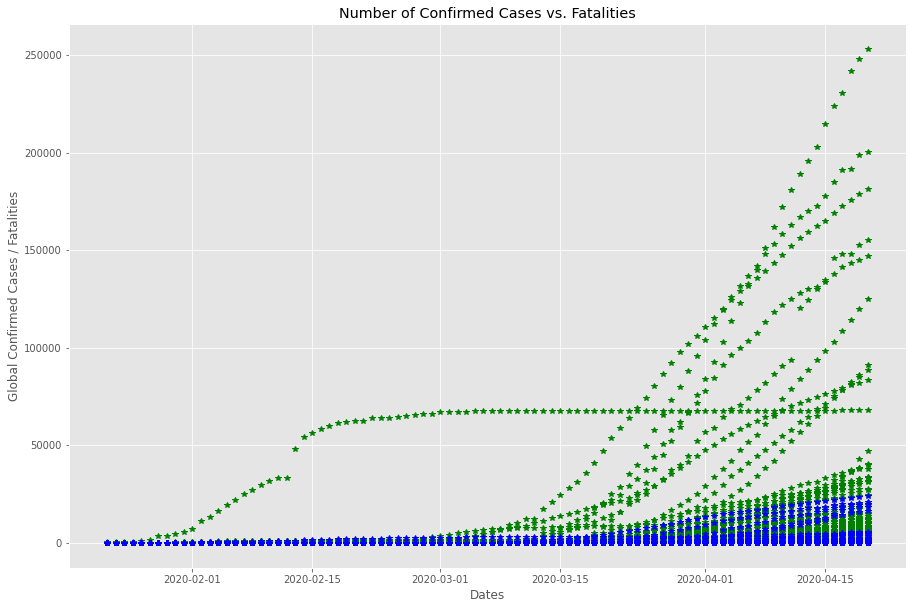

In [19]:
from matplotlib.dates import date2num

dates = date2num(X_train['date'])
plt.figure(figsize=[15,10])
plt.plot_date(dates, X_train['ConfirmedCases'], marker="*", color = 'green')
plt.plot_date(dates, X_train['Fatalities'], marker="*", color = 'blue')

plt.xlabel('Dates')
plt.ylabel('Global Confirmed Cases / Fatalities')
plt.title('Number of Confirmed Cases vs. Fatalities')
plt.show()

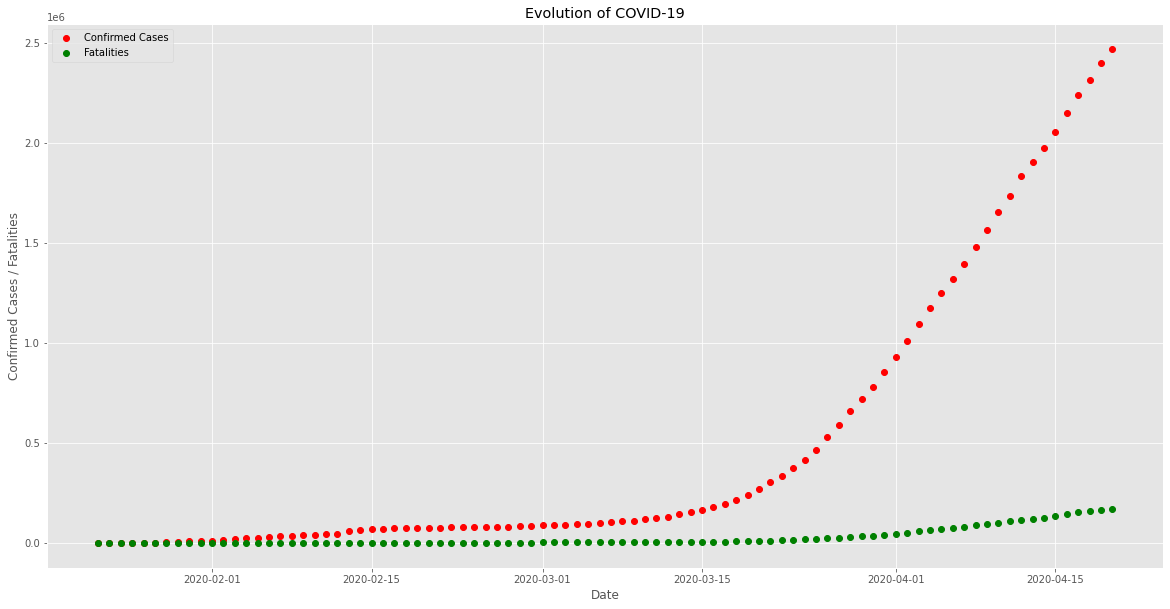

In [20]:
total_cases = X_train[['ConfirmedCases', 'Fatalities']].groupby(X_train['date'].dt.to_period('D')).sum()
total_cases = pd.DataFrame(total_cases, columns=['ConfirmedCases', 'Fatalities'])
total_cases.reset_index(inplace=True)
total_cases['date'] = pd.Series([date.to_timestamp().to_pydatetime() for date in total_cases['date'].values])

plt.figure(figsize=[20,10])
plt.plot_date(date2num(total_cases['date']), total_cases['ConfirmedCases'], color = 'red', label='Confirmed Cases')
plt.plot_date(date2num(total_cases['date']), total_cases['Fatalities'], color = 'green', label='Fatalities')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases / Fatalities')
plt.title('Evolution of COVID-19')
plt.legend()
plt.show()

In [21]:
import plotly.graph_objects as go

vis_bar_data = X_train.groupby(['Country_Region'])['ConfirmedCases', 'Fatalities'].sum()
vis_bar_data.sort_values('ConfirmedCases', inplace=True, ascending=False)
vis_bar_data.reset_index(inplace=True)
vis_bar_data = vis_bar_data[:10]

trace1 = go.Bar(x = vis_bar_data['Country_Region'], y = vis_bar_data['ConfirmedCases'], name = 'Confirmed Cases')
trace2 = go.Bar(x = vis_bar_data['Country_Region'], y = vis_bar_data['Fatalities'],  name = 'Fatalities')

data = [trace1, trace2]

fig = go.Figure(data = data)
fig.update_layout(barmode='overlay', title='Top 10 Countries with highest confirmed cases', xaxis_title="Countries", yaxis_title="Confirmed Cases / Fatalities")

fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [22]:
import plotly.express as px

vis_geo_data = X_train.groupby(['date', 'Country_Region'])['ConfirmedCases', 'Fatalities'].sum()
vis_geo_data.reset_index(inplace=True)
vis_geo_data['date'] = pd.to_datetime(vis_geo_data['date'])
vis_geo_data['date'] = vis_geo_data['date'].dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(vis_geo_data, 
                     locations='Country_Region', 
                     locationmode='country names', 
                     size='ConfirmedCases', 
                     title='Confirmed Cases Evolution', 
                     projection='natural earth', 
                     color='ConfirmedCases',
                     hover_name='Country_Region',
                     animation_frame='date', 
                     color_continuous_scale="portland")
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



## Stage 4: Data Prep

- The Kaggle data for the competition is preped. Categorical features are one-hot encoded and numerical features are normalized. Null values in the dataset are accounted for here.

In [0]:
X_valid.drop(['date', 'GINI index (World Bank estimate), average 2000-16'], axis=1, inplace=True)
X_train.drop(['date', 'GINI index (World Bank estimate), average 2000-16'], axis=1, inplace=True)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cat_vars = ['Province_State', 'Country_Region']
num_vars = ['hour', 'dayofweek',
       'quarter', 'month', 'dayofyear', 'dayofmonth', 'weekofyear',
       'Life Ladder', 'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption', 'Positive affect',
       'Negative affect', 'Confidence in national government',
       'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'gini of household income reported in Gallup, by wp5-year',
       'Estimated number of malaria cases',
       'Human development index (HDI) 2018', 'Life expectancy at birth 2018',
       'Expected years of schooling 2018', 'Mean years of schooling 2018',
       'Gross national income (GNI) per capita 2018', 'Population (2020)',
       'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %', 
        'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_vars)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('one_hot_encoder', OneHotEncoder()),
])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_vars)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [0]:
X_train_model = full_pipeline.fit_transform(X_train)
X_valid_model = full_pipeline.fit_transform(X_valid)

In [0]:
X_train_model = X_train_model.toarray()
X_valid_model = X_valid_model.toarray()

## Stage 5: Error Calculation

- Root Mean Squared Error and Root Mean Sqaured Log Error are used to calculate the performance of our trained models.

In [0]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmse(model, labels, data):
    preds = model.predict(data)
    preds = np.array(preds)
    preds[preds < 0] = 0
    preds = np.round(preds, 0)
    
    return np.sqrt(mean_squared_error(labels, preds))

In [0]:
def rmsle(model, labels, data):
    preds = model.predict(data)
    preds = np.array(preds)
    preds[preds < 0] = 0
    preds = np.round(preds, 0)
    
    return np.sqrt(mean_squared_log_error(labels, preds))

## Stage 5: Model Training

- XGBoost, Linear Regression, and Random Forest models are trained on the modified data.

### XGBoost Model

In [31]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

y_train = X_train[['ConfirmedCases', 'Fatalities']]

XGBoostModel = xgb.XGBRegressor(n_estimators=1000)
XGBoostModel.fit(X_train_model, y_train['ConfirmedCases'], verbose=True)

[20:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

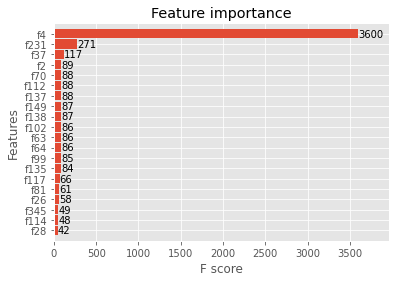

In [32]:
plot = plot_importance(XGBoostModel, height=0.9, max_num_features=20)

In [33]:
print('The RMSE predicting Confirmed Cases is: {}'.format(rmse(XGBoostModel, y_train['ConfirmedCases'], X_train_model)))
print('The RMLSE predicting Confirmed Cases is: {}'.format(rmsle(XGBoostModel, y_train['ConfirmedCases'], X_train_model)))

The RMSE predicting Confirmed Cases is: 2498.262428892084
The RMLSE predicting Confirmed Cases is: 2.463867844085419


In [34]:
XGBoostModel = xgb.XGBRegressor(n_estimators=1000)
XGBoostModel.fit(X_train_model, y_train['Fatalities'], verbose=True)

[20:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

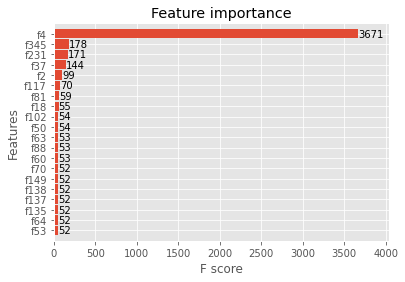

In [35]:
plot = plot_importance(XGBoostModel, height=0.9, max_num_features=20)

In [36]:
print('The RMSE for this XGB model predicting Fatalities is: {}'.format(rmse(XGBoostModel, y_train['Fatalities'], X_train_model)))
print('The RMLSE for this XGB model predicting Fatalities is: {}'.format(rmsle(XGBoostModel, y_train['Fatalities'], X_train_model)))

The RMSE for this XGB model predicting Fatalities is: 157.83472064642035
The RMLSE for this XGB model predicting Fatalities is: 1.5224805629209428


### Sci-Kit Learn Models

#### Linear Regression Model

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_model, y_train['ConfirmedCases'])

print('The RMSE predicting Confirmed Cases is: {}'.format(rmse(lin_reg, y_train['ConfirmedCases'], X_train_model)))
print('The RMLSE predicting Confirmed Cases is: {}'.format(rmsle(lin_reg, y_train['ConfirmedCases'], X_train_model)))

The RMSE predicting Confirmed Cases is: 8327.280509580094
The RMLSE predicting Confirmed Cases is: 3.0697273570583574


In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_model, y_train['Fatalities'])

print('The RMSE predicting Fatalities is: {}'.format(rmse(lin_reg, y_train['Fatalities'], X_train_model)))
print('The RMLSE predicting Fatalities is: {}'.format(rmsle(lin_reg, y_train['Fatalities'], X_train_model)))

The RMSE predicting Fatalities is: 773.8729699533529
The RMLSE predicting Fatalities is: 2.23129973390574


#### Random Forest Model

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, None],
 'min_samples_split': [2, 4, 6, 8], 
 'n_estimators': [100, 150, 200, 250, 300]}

rnd_forest = RandomForestRegressor(n_estimators = 200, n_jobs = -1)

grid = RandomizedSearchCV(estimator = rnd_forest,
                          param_distributions = params, 
                          n_iter = 50, 
                          verbose=2, 
                          random_state=42,
                          cv = 2,
                          n_jobs = -1)

rnd_forest.fit(X_train_model, y_train['ConfirmedCases'])

print('The RMSE predicting Confirmed Cases is: {}'.format(rmse(rnd_forest, y_train['ConfirmedCases'], X_train_model)))
print('The RMLSE predicting Confirmed Cases is: {}'.format(rmsle(rnd_forest, y_train['ConfirmedCases'], X_train_model)))

The RMSE predicting Confirmed Cases is: 160.20039378754367
The RMLSE predicting Confirmed Cases is: 0.15469890886477497


In [40]:
rnd_forest = RandomForestRegressor(n_estimators = 200, n_jobs = -1)
rnd_forest.fit(X_train_model, y_train['Fatalities'])

print('The RMSE predicting Fatalities is: {}'.format(rmse(rnd_forest, y_train['Fatalities'], X_train_model)))
print('The RMLSE predicting Fatalities is: {}'.format(rmsle(rnd_forest, y_train['Fatalities'], X_train_model)))

The RMSE predicting Fatalities is: 17.16522166855929
The RMLSE predicting Fatalities is: 0.06352501799844631


## Stage 6: Conclusion 

- According to the RMSE and RMSLE scores generated, the Random Forest model is the best one generated. 
- However, since labeled testing data is not available, it is not know if certian models have overfit the data.

### Steps for improvement

- This data analysis can be further improved by exploring and gaining more insights into the available data. Further data visualization could be useful in determining which features have a large impact in determining Confirmed Cases and Fatalities from the Coronavirus. Additionally, more time could be allocated to training different models and finding the best hyper-parameters. 
- If you have any questions or improvement suggestions, please feel free to contact me: rohan.ravindran24@gmail.com